In [108]:
import h5py
from scipy.interpolate import interp1d
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import savgol_filter
from scipy.signal import find_peaks
import seaborn as sns
import scipy as sp

In [158]:
vpr6_0001 = "../../SLEAP/vid_501b/temp-12062021143912-0000.v000.analysis.h5"
vpr6_001 = "../../SLEAP/vid_501b/temp-12062021144739-0000.mp4.predictions.analysis.h5"
vpr6_01 = "../../SLEAP/vid_501b/temp-12062021152724-0000.mp4.predictions.analysis.h5"
vpr6_1 = "../../SLEAP/vid_501b/temp-12062021153553-0000.mp4.predictions.analysis.h5"


HEAD_INDEX = 0
THORAX_INDEX = 1
WING_L_INDEX = 2
WING_R_INDEX = 3

In [159]:

def get_data(filename):
    with h5py.File(filename, "r") as f:
        dset_names = list(f.keys())
        locations = f["tracks"][:].T
        node_names = [n.decode() for n in f["node_names"][:]]
        
    return dset_names, locations, node_names

In [160]:
def fill_missing(Y, kind="linear"):
    """Fills missing values independently along each dimension after the first."""

    # Store initial shape.
    initial_shape = Y.shape

    # Flatten after first dim.
    Y = Y.reshape((initial_shape[0], -1))

    # Interpolate along each slice.
    for i in range(Y.shape[-1]):
        y = Y[:, i]

        # Build interpolant.
        x = np.flatnonzero(~np.isnan(y))
        f = interp1d(x, y[x], kind=kind, fill_value=np.nan, bounds_error=False)

        # Fill missing
        xq = np.flatnonzero(np.isnan(y))
        y[xq] = f(xq)
        
        # Fill leading or trailing NaNs with the nearest non-NaN values
        mask = np.isnan(y)
        y[mask] = np.interp(np.flatnonzero(mask), np.flatnonzero(~mask), y[~mask])

        # Save slice
        Y[:, i] = y

    # Restore to initial shape.
    Y = Y.reshape(initial_shape)
    return Y

In [161]:
def get_distance(thorax, wing):
    ## Abs Euclidean distance between thorax and wing
    
    return np.abs(np.linalg.norm(thorax-wing))

    

def get_angle(head_loc, thorax_loc, wing_l_loc, wing_r_loc):
    ## get angle between head and wing via thorax
    
    
    head_tho_r = head_loc[:,:,0] - thorax_loc[:,:,0]
    head_tho_l = head_loc[:,:,0] - thorax_loc[:,:,0]
    
    left_wing =  wing_l_loc[:,:,0] - thorax_loc[:,:,0] 
    right_wing = wing_r_loc[:,:,0] - thorax_loc[:,:,0] 

    cosine_angle_l = [np.dot(i, j)/(np.linalg.norm(i) * np.linalg.norm(j)) for i,j in zip(head_tho_l, left_wing)]
    cosine_angle_r = [np.dot(i, j)/(np.linalg.norm(i) * np.linalg.norm(j)) for i,j in zip(right_wing, head_tho_r)]

    angle_l = np.arccos(cosine_angle_l)
    angle_r = np.arccos(cosine_angle_r)

    return 180-np.degrees(angle_l), 180-np.degrees(angle_r) 



def get_velocity(node_loc, win=25, poly=3):
    """
    node_loc is a [frames, 2] array
    
    win defines the window to smooth over
    
    poly defines the order of the polynomial
    to fit with
    
    """
    node_loc_vel = np.zeros_like(node_loc)
    
    for c in range(node_loc.shape[-1]):
        node_loc_vel[:, c] = savgol_filter(node_loc[:, c], win, poly, deriv=1)
    
    node_vel = np.linalg.norm(node_loc_vel,axis=1)

    return node_vel



In [218]:
def get_metrics(name):
    
    min_thresh = 45
    max_thresh = 100
    
    remove_outliers = lambda x: np.where(x<max_thresh, x, 0)

    
    #get data
    dset_names, locations, node_names = get_data(name)
    locations = fill_missing(locations)

    head_loc = locations[:, HEAD_INDEX, :]
    thorax_loc = locations[:, THORAX_INDEX, :]
    wing_r_loc = locations[:, WING_R_INDEX, :]
    wing_l_loc = locations[:, WING_L_INDEX, :]
    

    ### calc metrics
    
    left_ang, right_ang = get_angle(head_loc, thorax_loc, wing_l_loc, wing_r_loc)   
    left_ang = remove_outliers(left_ang)
    right_ang = remove_outliers(right_ang)

    thorax_vel = get_velocity(thorax_loc[:, :, 0])

    #get singing (wing extensions)

    right_peak_ids,_ = find_peaks(right_ang, height=min_thresh)
    right_frames = np.array([i for i in range(len(right_ang))])

    left_peak_ids,_ = find_peaks(left_ang, height=min_thresh)
    left_frames = np.array([i for i in range(len(left_ang))])

    right_ipis = np.diff(right_frames[right_peak_ids])
    right_angles = right_ang[right_peak_ids]
    right_velocities = thorax_vel[right_peak_ids]
    
    left_ipis = np.diff(left_frames[left_peak_ids])
    left_angles = right_ang[left_peak_ids]
    left_velocities = thorax_vel[left_peak_ids]

    return {'right':{'peak_id':right_peak_ids,'ang':right_ang,'ipis':right_ipis,'peak_ang':right_angles, 
                     'peak_vel':right_velocities,  'frames':right_frames},
           'left':{'peak_id':left_peak_ids, 'ang':left_ang,'ipis':left_ipis,'peak_ang':left_angles, 
                   'peak_vel':left_velocities,  'frames':left_frames},
           'head':{'loc':head_loc},'thorax':{'loc':thorax_loc}}


In [219]:
data_0001 = get_metrics(vpr6_0001)
data_001 = get_metrics(vpr6_001)
data_01 = get_metrics(vpr6_01)
data_1 = get_metrics(vpr6_1)

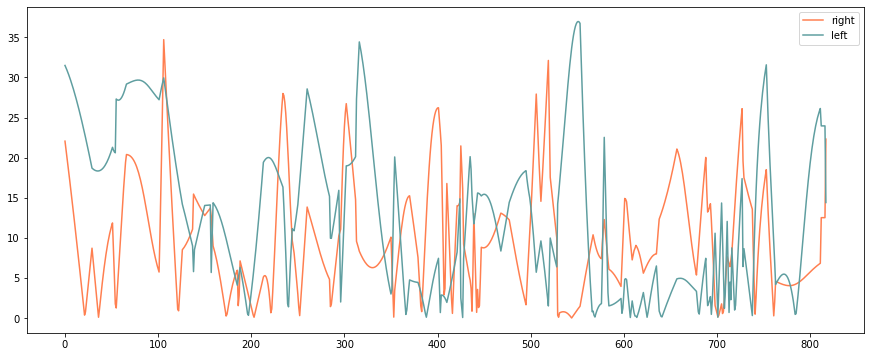

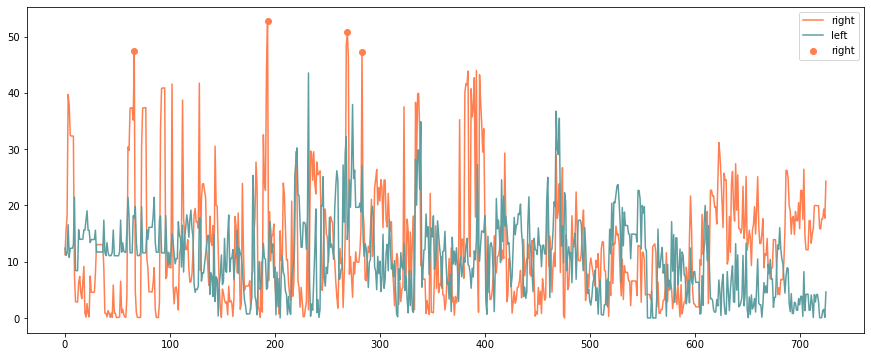

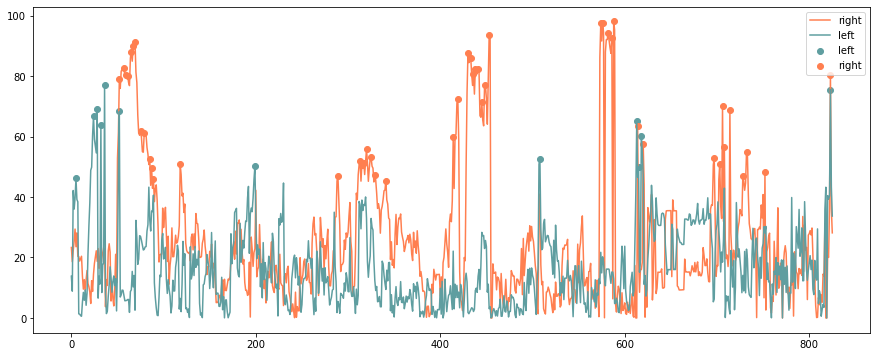

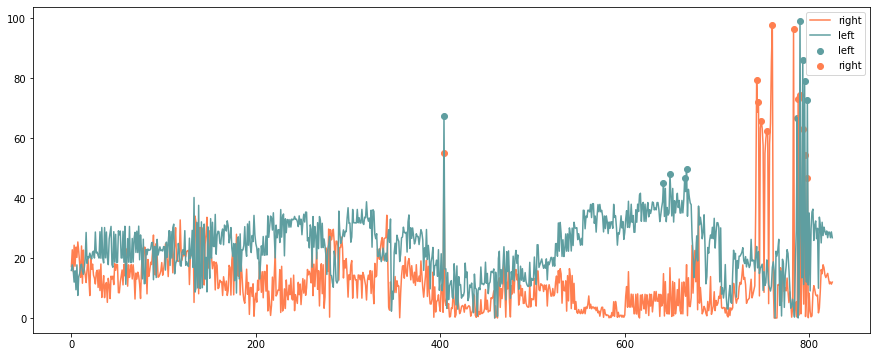

In [220]:
plt.figure(figsize=(15, 6))


plt.plot(data_0001['right']['ang'], c='coral',label='right')
plt.plot(data_0001['left']['ang'], c='cadetblue',label='left')
peak_l = data_0001['left']['peak_id']
peak_r = data_0001['right']['peak_id']
if len(peak_l)>0:
    plt.scatter(data_0001['left']['frames'][peak_l],data_0001['left']['ang'][peak_l],
                c='cadetblue',label='left')
if len(peak_r)>0:
    plt.scatter(data_0001['right']['frames'][peak_r],data_0001['right']['ang'][peak_r], 
                c='coral',label='right')

plt.legend()
plt.show()


plt.figure(figsize=(15, 6))
plt.plot(data_001['right']['ang'], c='coral',label='right')
plt.plot(data_001['left']['ang'], c='cadetblue',label='left')
peak_l = data_001['left']['peak_id']
peak_r = data_001['right']['peak_id']
if len(peak_l)>0:
    plt.scatter(data_001['left']['frames'][peak_l],data_001['left']['ang'][peak_l], 
                c='cadetblue',label='left')
if len(peak_r)>0:
    plt.scatter(data_001['right']['frames'][peak_r],data_001['right']['ang'][peak_r], 
                c='coral',label='right')
plt.legend()
plt.show()

plt.figure(figsize=(15, 6))
plt.plot(data_01['right']['ang'], c='coral',label='right')
plt.plot(data_01['left']['ang'], c='cadetblue',label='left')
peak_l = data_01['left']['peak_id']
peak_r = data_01['right']['peak_id']
if len(peak_l)>0:
    plt.scatter(data_01['left']['frames'][peak_l],data_01['left']['ang'][peak_l], 
                c='cadetblue',label='left')
if len(peak_r)>0:
    plt.scatter(data_01['right']['frames'][peak_r],data_01['right']['ang'][peak_r], 
                c='coral',label='right')
plt.legend()
plt.show()



plt.figure(figsize=(15, 6))
plt.plot(data_1['right']['ang'], c='coral',label='right')
plt.plot(data_1['left']['ang'], c='cadetblue',label='left')
peak_l = data_1['left']['peak_id']
peak_r = data_1['right']['peak_id']
if len(peak_l)>0:
    plt.scatter(data_1['left']['frames'][peak_l],data_1['left']['ang'][peak_l], 
                c='cadetblue',label='left')
if len(peak_r)>0:
    plt.scatter(data_1['right']['frames'][peak_r],data_1['right']['ang'][peak_r], 
                c='coral',label='right')
plt.legend()
plt.show()

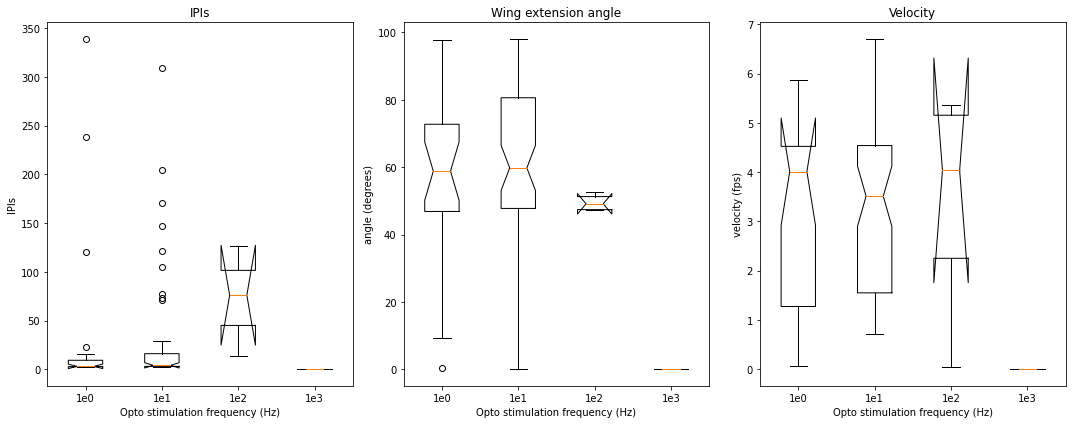

Text(0, 0.5, 'number of wing extensions')

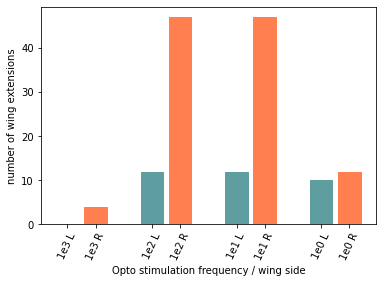

In [228]:
pos   = [1, 2, 3, 4]
label = ['1e3','1e2', '1e1', '1e0']
plt.figure(figsize=(15, 6))

ax = plt.subplot(131)
ax.set_title('IPIs')

plt.boxplot([0, np.hstack((data_001['left']['ipis'], data_001['right']['ipis'])), 
                np.hstack((data_01['left']['ipis'], data_01['right']['ipis'])),
                np.hstack((data_1['left']['ipis'], data_1['right']['ipis']))], 
               pos, vert=True)
plt.xlabel('Opto stimulation frequency (Hz)')
plt.ylabel('IPIs')

ax.set_xticks(pos)
ax.set_xticklabels(label)
plt.gca().invert_xaxis()

# plt.tight_layout()
# plt.show()

ax = plt.subplot(132)
ax.set_title('Wing extension angle')

plt.boxplot([0, np.hstack((data_001['left']['peak_ang'], data_001['right']['peak_ang'])), 
                np.hstack((data_01['left']['peak_ang'], data_01['right']['peak_ang'])),
                np.hstack((data_1['left']['peak_ang'], data_1['right']['peak_ang']))], 
               pos, vert=True)
ax.set_xticks(pos)
ax.set_xticklabels(label)
plt.xlabel('Opto stimulation frequency (Hz)')
plt.ylabel('angle (degrees)')
# plt.tight_layout()
plt.gca().invert_xaxis()

# plt.show()


ax = plt.subplot(133)
ax.set_title('Velocity')

plt.boxplot([0, np.hstack((data_001['left']['peak_vel'], data_001['right']['peak_vel'])), 
                np.hstack((data_01['left']['peak_vel'], data_01['right']['peak_vel'])),
                np.hstack((data_1['left']['peak_vel'], data_1['right']['peak_vel']))], 
               pos, vert=True)
ax.set_xticks(pos)
ax.set_xticks(pos)
ax.set_xticklabels(label)
plt.xlabel('Opto stimulation frequency (Hz)')
plt.ylabel('velocity (fps)')
plt.tight_layout()

plt.gca().invert_xaxis()


plt.show()


ax = plt.subplot(111)

barlist = plt.bar([1,2,4,5,7,8,10,11],[len(data_001['left']['peak_id']), len(data_001['right']['peak_id']), 
                                 len(data_01['left']['peak_id']), len(data_01['right']['peak_id']),
                len(data_01['left']['peak_id']), len(data_01['right']['peak_id']),
                len(data_1['left']['peak_id']), len(data_1['right']['peak_id'])])

barlist[0].set_color('cadetblue')
barlist[2].set_color('cadetblue')
barlist[4].set_color('cadetblue')
barlist[6].set_color('cadetblue')


barlist[1].set_color('coral')
barlist[3].set_color('coral')
barlist[5].set_color('coral')
barlist[7].set_color('coral')

ax.set_xticks([1,2,4,5,7,8,10,11])

ax.set_xticklabels(['1e3 L', '1e3 R', '1e2 L', '1e2 R','1e1 L', '1e1 R','1e0 L','1e0 R'], rotation=65)

plt.xlabel('Opto stimulation frequency / wing side')
plt.ylabel('number of wing extensions')

In [68]:
# # plt.figure()
# # plt.plot(left_dist, label='left_dist')
# # plt.plot(right_dist, label='right_dist')

# # plt.xlabel('frame')
# # plt.ylabel('abs Euclidean distance')

# # plt.legend()
# # plt.show()


# plt.figure()
# plt.plot(left_ang, label='left_ang')
# plt.plot(right_ang, label='right_ang')

# plt.xlabel('frame')
# plt.ylabel('extension angle (degrees)')

# plt.legend()
# plt.show()

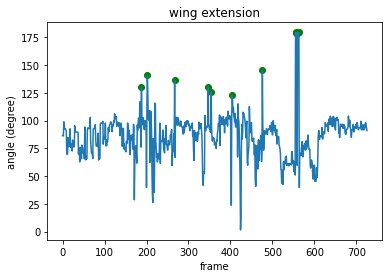

In [82]:
peak_ids,_ = find_peaks(right_ang, height=120)
frames = np.array([i for i in range(len(right_ang))])
plt.title('wing extension')
plt.plot(frames, right_ang, label='right_ang')
plt.scatter(frames[peak_ids], right_ang[peak_ids], label='right_ang', color='green')
plt.xlabel('frame')
plt.ylabel('angle (degree)')

plt.show()

In [53]:
ipis = np.diff(frames[peak_ids])
angles = right_ang[peak_ids]
velocities = thorax_vel[peak_ids]

In [58]:

#plt.scatter(thorax_loc[:, 0, 0], thorax_loc[:, 1, 0], c=thorax_vel, s=4,)
#plt.plot(thorax_vel)
